## In this notebook we are going to make the analysis of the results of the meta-analysis of our model parameters.

#### To recap , we have taken the model of our beam, which has it's diameter and youngs modulus defined by stochastic processes, and have applied to it a force on the center of a beam, where the forces norm and offset from the middle of the beam are determined by scalar normal laws

The goal was to study the impact of the model parameters on the results of a sensitivity analysis, as well as the impacts of varying the metamodel parameters, and Karhunen Loeve parameters on this analysis 

In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, os, sys


Bad key savefig.frameon in file /home/kramer84/anaconda3/envs/ot_traits_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/kramer84/anaconda3/envs/ot_traits_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/kramer84/anaconda3/envs/ot_traits_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log fi

In [2]:
analysis_dirs = os.listdir('./meta_analysis_results')

In [3]:
lhs_params = ['young','scaleYoung','diam','scaleDiam',
              'forcePos','forceNorm']
size_lhs = len(analysis_dirs)
lhs_doe = np.zeros((size_lhs, 6))
for i in range(size_lhs):
    lhs_doe[i,...]= re.findall(r"[-+]?\d*\.\d+|\d+", analysis_dirs[i])

Now we are going to organize the data so that we have the LHS, then the three nu values, and then the different thresholds. We will first organize it in a numpy array

In [4]:
# size_lhs, n_nu, n_thresh, sobol_E, sobol_D, sobol_FP, sobol_FN 
# for the model we have only one evaluation
meta_analysis_array_model   = np.zeros((size_lhs, 3, 3, 4, 3))
# for the metamodel we have an envaluation with 3 different LHS sizes
meta_analysis_array_mm1000  = np.zeros((size_lhs, 3, 3, 3, 4, 3))
meta_analysis_array_mm50000 = np.zeros((size_lhs, 3, 3, 3, 4, 3))
# size_lhs, n_nu, n_thresh, kl_dim
kl_dimension_array  = np.zeros((size_lhs, 3, 3))
nu_array = np.zeros((size_lhs, 3, 3))
thresh_array = np.zeros((size_lhs, 3, 3))
for k_lhs in range(size_lhs):
    thresh_paths = os.listdir(os.path.join('./meta_analysis_results',analysis_dirs[k_lhs]))
    for k_thresh in range(3):
        thresh_path = thresh_paths[k_thresh]
        thresh_val = re.findall("-?\d+.?\d*(?:[Ee]-\d+)?", thresh_path)[0]
        nu_paths = os.listdir(os.path.join('./meta_analysis_results',
                                      analysis_dirs[k_lhs], 
                                      thresh_paths[k_thresh]))
        for k_nu in range(3):
            nu_path = nu_paths[k_nu]
            nu_val = re.findall(r"[-+]?\d*\.\d+|\d+",nu_path)[0]
            csv_path = os.path.join('./meta_analysis_results',
                                   analysis_dirs[k_lhs],
                                   thresh_path,
                                   nu_path)
            sample = ot.Sample_ImportFromCSVFile(csv_path)
            kl_dimension_array[k_lhs, k_nu, k_thresh] = sample[0,3]
            nu_array[k_lhs, k_nu, k_thresh] = nu_val
            thresh_array[k_lhs, k_nu, k_thresh] = thresh_val
            meta_analysis_array_model[
                k_lhs, k_nu, k_thresh, ...] = np.reshape(np.array(sample[0,4:]),(4,3))
            # Here we iterate over the 3 LHS sizes (25,50,100)
            for i_lhs in range(3):
                meta_analysis_array_mm1000[k_lhs, k_nu, k_thresh, i_lhs, 
                    ...] = np.reshape(np.array(sample[4 + i_lhs ,4:]),(4,3))
                meta_analysis_array_mm50000[k_lhs, k_nu, k_thresh, i_lhs, 
                    ...] = np.reshape(np.array(sample[1 + i_lhs ,4:]),(4,3))

In [5]:
print(lhs_doe[0])
print(kl_dimension_array[0][2][2])
print(nu_array[0][2][2])
print(thresh_array[0][2][2])

[8.1820e+03 5.5500e+02 3.1130e-01 4.5500e+02 9.1450e+01 1.9236e+01]
11.0
0.5
0.1


In [28]:
# Here we print the data for the lhs realization above, with a nu of 0.5 and threshold of 0.1
print(meta_analysis_array_model[0][2][2])
q=meta_analysis_array_model[0,2,2,:,1:]
print(q)
print(np.array([q[:,0],q[:,1]]))
print(meta_analysis_array_mm1000[0][2][2][2][3])
print(meta_analysis_array_mm50000[0][2][2][0][3])

[[-0.02566 -0.09173  0.05086]
 [ 0.16492  0.09053  0.24452]
 [ 0.04034 -0.02812  0.12182]
 [ 0.66988  0.63072  0.70851]]
[[-0.09173  0.05086]
 [ 0.09053  0.24452]
 [-0.02812  0.12182]
 [ 0.63072  0.70851]]
[[-0.09173  0.09053 -0.02812  0.63072]
 [ 0.05086  0.24452  0.12182  0.70851]]
[0.68945696 0.65405589 0.72303096]
[0.70559899 0.70076702 0.71001431]


Now that we have gotten our data, we will have to plot in a manner wich makes the data understandable.
We will try to make the data understandable in one plot. 
For that, we will make an interactive plot, where we can change the realization of the LHS, as well as change the NU parameter of the stochastic fields.
All the other data will have to be plotted on one image.

Let's plot for now only one part of our data, for testing purposes

In [55]:
fig = plt.Figure()
ax = fig.add_subplot(111)
xlabels = ['SE', 'SD', 'SFN', 'SFP']
errbar = ax.errorbar(x = [0,1,2,3] , 
            y = [0,0,0,0], 
            yerr=[[.5,.5,.5,.5],[.5,.5,.5,.5]],
            fmt='s', color='r', ecolor='r')

offset = 0.1
errbar = ax.errorbar(x = np.array([0,1,2,3])+offset , 
            y = [0,0,0,0], 
            yerr=[[.5,.5,.5,.5],[.5,.5,.5,.5]],
            fmt='s', color='b', ecolor='g')

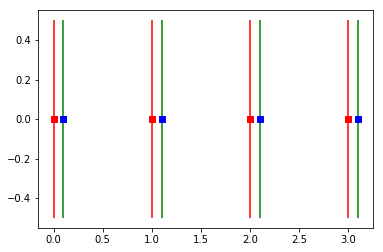

In [56]:
fig